<a href="https://colab.research.google.com/github/krrish9973/NLP-Use-case/blob/main/Image_Classification_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧠 Image Classification System using EfficientNet  
This notebook implements an image classification system as part of the Computer Vision Project (Phase 2).  
We use **EfficientNet** as the backbone and apply transfer learning on a small dataset.  
The workflow includes dataset preparation, data augmentation, model definition, training, evaluation, and visualization of results.

## Check for GPU


In [1]:
!nvidia-smi

Sun Oct 12 08:48:52 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   32C    P0             46W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----


## 1. Imports & Setup (Code)

In [2]:
import os
import random
import time
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
import timm  # for EfficientNet and other pretrained models

# Set random seeds for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
# Create EffNetB2 pretrained weights, transforms and model
weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
data_transforms = weights.transforms()

# =============================
# MODEL DEFINITION
# =============================

# Load EfficientNet-B2 pretrained model
model = timm.create_model('efficientnet_b2', pretrained=True)
# model
data_transforms

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/36.8M [00:00<?, ?B/s]

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

## 2. Dataset Preparation (Code)

In [4]:
# =============================
# 2. DATASET PREPARATION
# =============================

# Create CIFAR-10 training data transforms
cifar10_train_transforms = torchvision.transforms.Compose([
    # torchvision.transforms.RandomCrop(32, padding=4),
    torchvision.transforms.RandomHorizontalFlip(0.1),
    # torchvision.transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    # torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    torchvision.transforms.TrivialAugmentWide(),
    data_transforms
])

# Now let's compare cifar10_train_transforms (for the training data) and effnetb2_transforms (for the testing/inference data).
print(f"Training transforms:\n{cifar10_train_transforms}\n")
print(f"Testing transforms:\n{data_transforms}")

Training transforms:
Compose(
    RandomHorizontalFlip(p=0.1)
    TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)
)

Testing transforms:
ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


## 3. Getting Data


In [5]:
from torchvision import datasets

# Setup data directory
from pathlib import Path
data_dir = Path("data")

# Get training data
train_data = datasets.CIFAR10(root=data_dir, # path to download data to
                              train=True, # dataset split to get
                              transform=cifar10_train_transforms, # perform transformation on training data
                              download=True) # want to download?

# Get testing data
test_data = datasets.CIFAR10(root=data_dir,
                             train=False,
                             transform=data_transforms, # perform normal EffNetB2 transforms on test data
                             download=True)
len(train_data), len(test_data)

100%|██████████| 170M/170M [00:14<00:00, 11.4MB/s]


(50000, 10000)

### Take only 50% data In consideration of the project limitations (data <100 MB and time

In [6]:
from torch.utils.data import Subset

# Take only 50% of the data
train_size = len(train_data)
test_size = len(test_data)

# Create indices for 50% of data
train_indices = list(range(0, train_size, 2))  # Take every other sample
test_indices = list(range(0, test_size, 2))

# Create subsets
train_data_50 = Subset(train_data, train_indices)
test_data_50 = Subset(test_data, test_indices)

# Calculate sizes in MB (CIFAR-10: 32x32x3 bytes per image + 4 bytes per label)
bytes_per_image = 32 * 32 * 3 + 4
total_train_mb = (train_size * bytes_per_image) / (1024 * 1024)
total_test_mb = (test_size * bytes_per_image) / (1024 * 1024)
train_50_mb = (len(train_data_50) * bytes_per_image) / (1024 * 1024)
test_50_mb = (len(test_data_50) * bytes_per_image) / (1024 * 1024)

print(f"Original train size: {train_size} samples, {total_train_mb:.1f} MB")
print(f"50% train size: {len(train_data_50)} samples, {train_50_mb:.1f} MB")
print(f"Original test size: {test_size} samples, {total_test_mb:.1f} MB")
print(f"50% test size: {len(test_data_50)} samples, {test_50_mb:.1f} MB")
print(f"📊 Train samples: {len(train_data_50)}")
print(f"📊 Test samples: {len(test_data_50)}")
print(f"📁 Classes: {train_data.classes}")

Original train size: 50000 samples, 146.7 MB
50% train size: 25000 samples, 73.3 MB
Original test size: 10000 samples, 29.3 MB
50% test size: 5000 samples, 14.7 MB
📊 Train samples: 25000
📊 Test samples: 5000
📁 Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


### Visualizing the few Data/Images as Tensors



In [7]:
train_data[0][0]

tensor([[[-1.5014, -1.5014, -1.5014,  ...,  0.1426,  0.1426,  0.1426],
         [-1.5185, -1.5185, -1.5185,  ...,  0.1254,  0.1254,  0.1254],
         [-1.5185, -1.5185, -1.5185,  ...,  0.1254,  0.1254,  0.1254],
         ...,
         [ 0.6221,  0.6221,  0.6221,  ..., -0.4739, -0.4739, -0.4911],
         [ 0.6221,  0.6221,  0.6221,  ..., -0.4739, -0.4739, -0.4911],
         [ 0.6221,  0.6221,  0.6221,  ..., -0.4568, -0.4568, -0.4739]],

        [[-1.4055, -1.4055, -1.4055,  ..., -0.2850, -0.2850, -0.2850],
         [-1.4230, -1.4230, -1.4230,  ..., -0.3025, -0.3025, -0.3025],
         [-1.4230, -1.4230, -1.4230,  ..., -0.3025, -0.3025, -0.3025],
         ...,
         [ 0.2052,  0.2052,  0.2052,  ..., -0.9328, -0.9328, -0.9503],
         [ 0.2052,  0.2052,  0.2052,  ..., -0.9153, -0.9153, -0.9328],
         [ 0.2052,  0.2052,  0.2052,  ..., -0.9153, -0.9153, -0.9328]],

        [[-1.1770, -1.1770, -1.1770,  ...,  0.0082,  0.0082,  0.0082],
         [-1.1944, -1.1944, -1.1944,  ..., -0

## Convert Data into`DataLoader`'s

In [8]:
import os

# Set the batch size
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

# Create data loaders
train_dataloader = torch.utils.data.DataLoader(dataset=train_data_50, # Taking Subset of Data
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               num_workers=NUM_WORKERS,
                                               pin_memory=True)

test_dataloader = torch.utils.data.DataLoader(dataset=test_data_50,
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               num_workers=NUM_WORKERS,
                                               pin_memory=True)

print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x78284b34d730>, <torch.utils.data.dataloader.DataLoader object at 0x782946b78050>)
Length of train dataloader: 782 batches of 32
Length of test dataloader: 157 batches of 32


### 1. Check a single image Details

In [9]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[2], label_batch[2]

# View the batch shapes
image.shape, label

(torch.Size([3, 288, 288]), tensor(3))

### Plot the image and its label with matplotlib

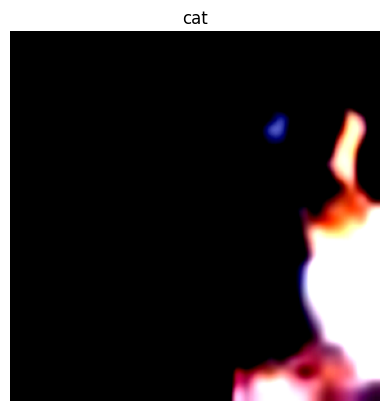

In [10]:
class_names = train_data.classes
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

### Plot more images Randomly

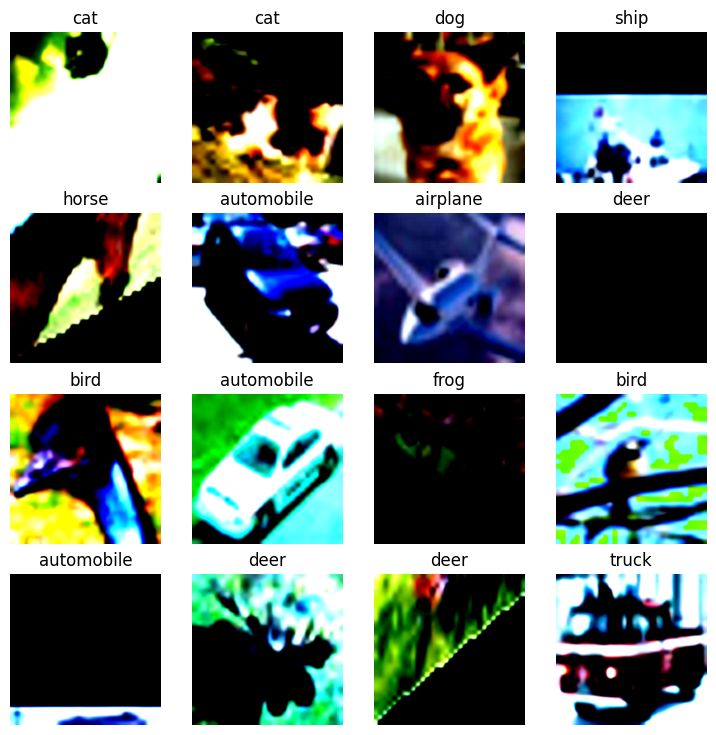

In [11]:
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data_50), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.permute(1,2,0), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False);

## Check and Analyze the different layers with torchinfo

In [12]:
!pip install torchinfo
from torchinfo import summary

# # Print a summary of Model
summary(model=model,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                        [32, 3, 224, 224]    [32, 1000]           --                   True
├─Conv2d (conv_stem)                               [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
├─BatchNormAct2d (bn1)                             [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    └─Identity (drop)                             [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─SiLU (act)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
├─Sequential (blocks)                              [32, 32, 112, 112]   [32, 352, 7, 7]      --                   True
│    └─Sequential (0)                              [32, 32, 112, 112]   [32, 16, 112, 112]   --                   True
│    │    └─DepthwiseSeparableConv (0)         

In [13]:
# Freeze backbone layers to train only the classification head
for name, param in model.named_parameters():
    if "classifier" not in name:
        param.requires_grad = False

# # Replace the classifier head to match the number of classes in our dataset
num_classes = len(train_data.classes)
in_features = model.classifier.in_features
# model.classifier = nn.Linear(in_features, num_classes)
# Add a slightly more complex classifier
model.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(512, num_classes)
)

# model.classifier = nn.Sequential(
#     nn.Dropout(0.4),  # Increased dropout
#     nn.Linear(in_features, 768),  # Balanced size
#     nn.BatchNorm1d(768),
#     nn.ReLU(),
#     nn.Dropout(0.3),
#     nn.Linear(768, num_classes)
# )


model = model.to(device)
print("✅ Model loaded and customized for classification")
# model

✅ Model loaded and customized for classification


## Check Freezed Layer with torchinfo

In [14]:
summary(model=model,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                        [32, 3, 224, 224]    [32, 10]             --                   Partial
├─Conv2d (conv_stem)                               [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
├─BatchNormAct2d (bn1)                             [32, 32, 112, 112]   [32, 32, 112, 112]   64                   False
│    └─Identity (drop)                             [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─SiLU (act)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
├─Sequential (blocks)                              [32, 32, 112, 112]   [32, 352, 7, 7]      --                   False
│    └─Sequential (0)                              [32, 32, 112, 112]   [32, 16, 112, 112]   --                   False
│    │    └─DepthwiseSeparableConv (0)  

# Define Function for Calculating the Accuracy

In [15]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
  acc = (correct / len(y_pred)) * 100
  return acc

# Train the Model

In [16]:
# =============================
# OPTIMIZED TRAINING LOOP (Clean & Efficient)
# =============================

from timeit import default_timer as timer

#Start time
train_time_start = timer()

#Number of Epochs
num_epochs = 25

criterion = nn.CrossEntropyLoss(label_smoothing=0.05) # For Image classification
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.05)
# optimizer = optim.AdamW(model.parameters(), lr=5e-3, weight_decay=0.05)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)


train_losses, test_losses = [], []
train_accs, test_accs = [], []

for epoch in range(num_epochs):
  print(f"Epoch: {epoch+1}/{num_epochs}\t-------\t", end=" ")

  ### Training
  train_loss, train_correct, train_total = 0.0, 0, 0

  for batch, (images, labels) in enumerate(train_dataloader):
    images, labels = images.to(device), labels.to(device)

    model.train()

    # 1. Forward pass
    outputs = model(images)

    # 2. Calculate loss
    loss = criterion(outputs, labels)
    train_loss += loss.item()

    # 3. Calculate accuracy efficiently
    preds = outputs.argmax(dim=1)  # No softmax needed for argmax
    train_correct += (preds == labels).sum().item()
    train_total += len(labels)

    # 4. Backward pass with gradient clipping
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

    optimizer.step()

    # Print progress
    # if batch % 500 == 0:
    #     print(f"Looked at {batch * len(images)}/{len(train_dataloader.dataset)} samples")

  # Calculate epoch metrics
  train_loss /= len(train_dataloader)
  train_acc = (train_correct / train_total) * 100

  ### Testing
  test_loss, test_correct, test_total = 0.0, 0, 0

  model.eval()
  with torch.inference_mode():
    for images_test, labels_test in test_dataloader:
      images_test, labels_test = images_test.to(device), labels_test.to(device)

      # Forward pass
      outputs_test = model(images_test)
      test_loss += criterion(outputs_test, labels_test).item()

      # Calculate accuracy
      preds = outputs_test.argmax(dim=1)
      test_correct += (preds == labels_test).sum().item()
      test_total += len(labels_test)

    test_loss /= len(test_dataloader)
    test_acc = (test_correct / test_total) * 100

  # Update learning rate
  scheduler.step()

  # Store metrics
  train_losses.append(train_loss)
  test_losses.append(test_loss)
  train_accs.append(train_acc)
  test_accs.append(test_acc)

  # Print results
  print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.2f}% Test loss:  {test_loss:.5f} | Test acc:  {test_acc:.2f}%")

# Calculate training time
train_time_end = timer()
total_time = train_time_end - train_time_start
print(f"Train time on {device}: {total_time:.3f} seconds")

Epoch: 1/25	-------	 Train loss: 1.31010 | Train acc: 59.87% Test loss:  0.77353 | Test acc:  82.20%
Epoch: 2/25	-------	 Train loss: 1.18330 | Train acc: 64.73% Test loss:  0.76230 | Test acc:  82.72%
Epoch: 3/25	-------	 Train loss: 1.15692 | Train acc: 66.07% Test loss:  0.74948 | Test acc:  82.78%
Epoch: 4/25	-------	 Train loss: 1.13617 | Train acc: 66.39% Test loss:  0.72423 | Test acc:  83.88%
Epoch: 5/25	-------	 Train loss: 1.11512 | Train acc: 67.46% Test loss:  0.71639 | Test acc:  84.44%
Epoch: 6/25	-------	 Train loss: 1.11240 | Train acc: 67.63% Test loss:  0.70776 | Test acc:  84.72%
Epoch: 7/25	-------	 Train loss: 1.09780 | Train acc: 68.23% Test loss:  0.70055 | Test acc:  84.96%
Epoch: 8/25	-------	 Train loss: 1.07944 | Train acc: 69.03% Test loss:  0.69710 | Test acc:  85.52%
Epoch: 9/25	-------	 Train loss: 1.08246 | Train acc: 68.98% Test loss:  0.69044 | Test acc:  85.20%
Epoch: 10/25	-------	 Train loss: 1.05939 | Train acc: 70.17% Test loss:  0.70031 | Test ac

# Visualize Train/Test Loss and Accuracy graphically

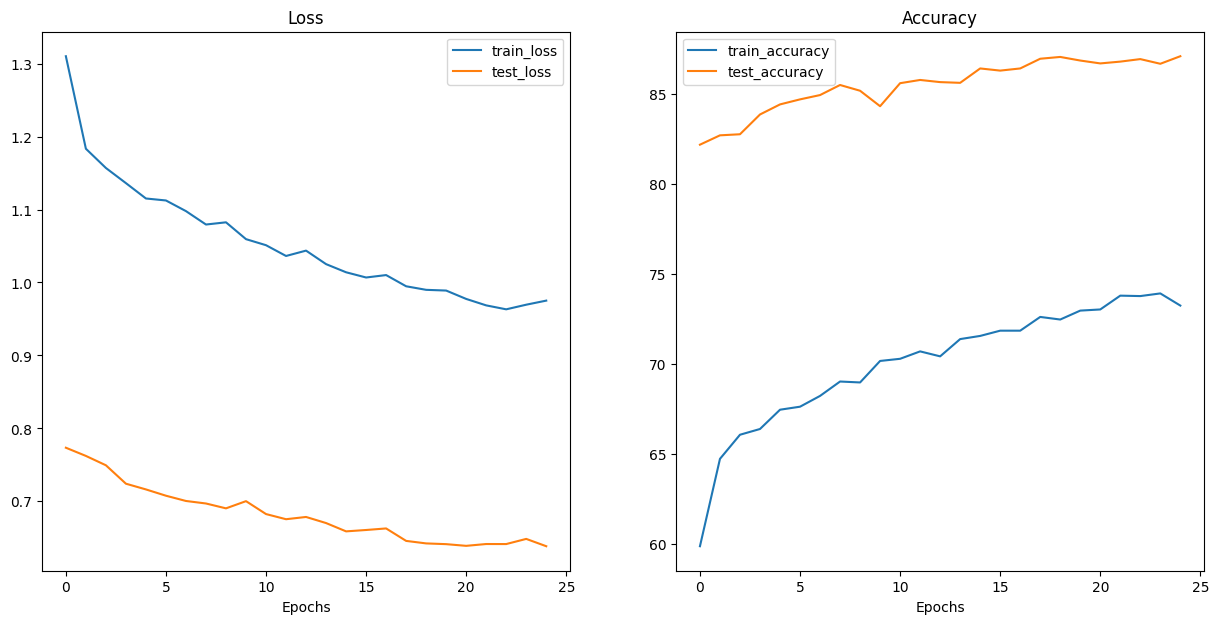

In [17]:
plt.figure(figsize=(15, 7))
# Plot loss
epochs = range(len(train_losses))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="train_loss")
plt.plot(epochs, test_losses, label="test_loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accs, label="train_accuracy")
plt.plot(epochs, test_accs, label="test_accuracy")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.legend()

# Testing/Prediction with confidence on Random Test Data

Predicting first 5 CIFAR-10 test images:
------------------------------------------------------------
Image 1: True=     truck, Predicted=     truck, Confidence= 26.4%, Correct=True
Image 2: True=      ship, Predicted=      ship, Confidence= 68.8%, Correct=True
Image 3: True=       dog, Predicted=       cat, Confidence= 45.8%, Correct=False
Image 4: True=      ship, Predicted=      ship, Confidence= 73.9%, Correct=True
Image 5: True=  airplane, Predicted=  airplane, Confidence= 94.1%, Correct=True


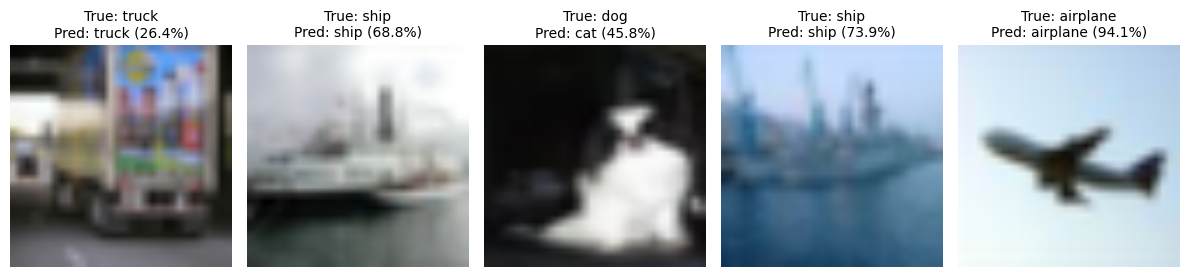


Accuracy on first 5 images: 80.0%


In [18]:
# Predict on CIFAR-10 test images with confidence and display in 3 columns
from torchvision.datasets import CIFAR10
from torchvision import transforms
import torch
import matplotlib.pyplot as plt

# Load CIFAR-10 test set
transform = transforms.Compose([
    transforms.Resize((288, 288)),
    transforms.ToTensor(),
])

testset = CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Evaluate model
model.eval()
correct = 0
total = 0

# Collect predictions for first 5 images
images, titles = [], []
print("Predicting first 5 CIFAR-10 test images:")
print("-" * 60)

with torch.no_grad():
    for i, (image, label) in enumerate(testloader):
        if i >= 5:  # Only first 5 images
            break

        image, label = image.cuda(), label.cuda()
        output = model(image)
        probabilities = torch.softmax(output[0], dim=0)
        predicted_idx = torch.argmax(probabilities).item()
        confidence = probabilities[predicted_idx].item()

        true_class = class_names[label.item()]
        pred_class = class_names[predicted_idx]
        is_correct = (predicted_idx == label.item())

        title = f"True: {true_class}\nPred: {pred_class} ({confidence:.1%})"
        images.append(image[0].cpu().permute(1, 2, 0))
        titles.append(title)

        print(f"Image {i+1}: True={true_class:>10}, Predicted={pred_class:>10}, Confidence={confidence:>6.1%}, Correct={is_correct}")

        if is_correct:
            correct += 1
        total += 1

# Plot images in a 3-column grid
cols = 5
rows = (len(images) + cols - 1) // cols
plt.figure(figsize=(12, 4 * rows))

for idx, img in enumerate(images):
    plt.subplot(rows, cols, idx + 1)
    plt.imshow(img)
    plt.title(titles[idx], fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()

accuracy = 100 * correct / total
print(f"\nAccuracy on first 5 images: {accuracy:.1f}%")

# Saving the Model

In [20]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "cifar_10_Image_classification_system.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/cifar_10_Image_classification_system.pth


# Loading a saved PyTorch model's state_dict()

In [21]:
loaded_model = model   # A user defined function needs to be defined for creating model which follows the sequence of process for creating the object. For now this part is skipped
loaded_model.load_state_dict(
    torch.load(
        f="models/cifar_10_Image_classification_system.pth",
        map_location=torch.device("cpu"),  # load to CPU
    )
)
#loaded_model

<All keys matched successfully>

In [23]:
from PIL import Image
from torchvision import transforms
import torch
import matplotlib.pyplot as plt

# --- 1. SETUP: Class Names and Device ---
# Define class names (used for CIFAR-10)
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Check for CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- 2. PREDICTION FUNCTION ---
def predict_single_image(model, image_path, class_names, device):
    """
    Loads, preprocesses, and predicts the class of a single image from a path.
    """
    # Define Transforms, including the standard ImageNet normalization
    transform = transforms.Compose([
        transforms.Resize((288, 288)),  # Input size used in your notebook
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # 1. Load and Transform Image
    try:
        # Load the image using PIL and ensure it's RGB
        image = Image.open(image_path).convert('RGB')
    except FileNotFoundError:
        print(f"Error: Image file not found at '{image_path}'")
        return

    # Apply transformations and add a batch dimension (B, C, H, W)
    image_tensor = transform(image).unsqueeze(0).to(device)

    # 2. Run Inference
    model.eval() # Set model to evaluation mode
    with torch.no_grad():
        output = model(image_tensor)
        probabilities = torch.softmax(output[0], dim=0) # Apply softmax for confidence scores

        # Get the class with the highest probability
        predicted_idx = torch.argmax(probabilities).item()
        confidence = probabilities[predicted_idx].item()
        pred_class = class_names[predicted_idx]

    # 3. Display Result
    plt.figure(figsize=(4, 4))
    # Display the original PIL image (no need to invert colors/tensors)
    plt.imshow(image)

    title = f"Prediction: {pred_class}\nConfidence: {confidence:.2%}"
    plt.title(title, fontsize=12, color='green' if confidence > 0.5 else 'red')
    plt.axis('off')
    plt.show()

    print(f"✅ Prediction Complete:")
    print(f"   Predicted Class: {pred_class}")
    print(f"   Confidence: {confidence:.2%}")

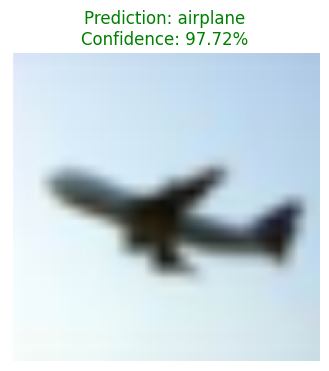

✅ Prediction Complete:
   Predicted Class: airplane
   Confidence: 97.72%


In [25]:
# --- 3. EXAMPLE USAGE ---
# ⚠️ IMPORTANT: Replace 'path/to/your/image.jpg' with the actual path to your image file.
#                Ensure your 'model' object is loaded and moved to the 'device' before running.

Example_Image_Path = 'examples/airplane.png'
predict_single_image(model, Example_Image_Path, class_names, device)